# Intel Image Classification : an `Image Classification` Problem

Source: https://www.kaggle.com/puneet6060/intel-image-classification

In [1]:
import boto3
import sagemaker
import json
import numpy as np
from PIL import Image

## Preparing image datasets

The Computer Vision algorithms in SageMaker support three input formats:

- Image files
- RecordIO files
- Augmented manifests built by SageMaker Ground Truth

For this DEMO we are going to use `Image files` format

## Data Preparation

In [2]:
!aws s3 cp s3://aws-ml-demo-2020/scenedataset.zip .

download: s3://aws-ml-demo-2020/scenedataset.zip to ./scenedataset.zip


In [3]:
!unzip scenedataset.zip

Archive:  scenedataset.zip
   creating: scenedataset/
  inflating: __MACOSX/._scenedataset  
   creating: scenedataset/pred/
  inflating: scenedataset/.DS_Store  
  inflating: __MACOSX/scenedataset/._.DS_Store  
   creating: scenedataset/train/
   creating: scenedataset/val/
  inflating: scenedataset/pred/63.jpg  
  inflating: __MACOSX/scenedataset/pred/._63.jpg  
  inflating: scenedataset/pred/24084.jpg  
  inflating: __MACOSX/scenedataset/pred/._24084.jpg  
  inflating: scenedataset/pred/13628.jpg  
  inflating: __MACOSX/scenedataset/pred/._13628.jpg  
  inflating: scenedataset/pred/3578.jpg  
  inflating: __MACOSX/scenedataset/pred/._3578.jpg  
  inflating: scenedataset/pred/10321.jpg  
  inflating: __MACOSX/scenedataset/pred/._10321.jpg  
  inflating: scenedataset/pred/10447.jpg  
  inflating: __MACOSX/scenedataset/pred/._10447.jpg  
  inflating: scenedataset/pred/12250.jpg  
  inflating: __MACOSX/scenedataset/pred/._12250.jpg  
  inflating: scenedataset/pred/1409.jpg  
  inflating

In [4]:
!pwd

/home/ec2-user/SageMaker


In [5]:
!ls scenedataset/

pred  train  val


In [6]:
!du -h scenedataset

120M	scenedataset/pred
37M	scenedataset/train/glacier
37M	scenedataset/train/buildings
42M	scenedataset/train/street
36M	scenedataset/train/mountain
49M	scenedataset/train/forest
32M	scenedataset/train/sea
231M	scenedataset/train
8.5M	scenedataset/val/glacier
7.4M	scenedataset/val/buildings
8.6M	scenedataset/val/street
7.6M	scenedataset/val/mountain
11M	scenedataset/val/forest
7.1M	scenedataset/val/sea
50M	scenedataset/val
400M	scenedataset


In [7]:
!wget https://raw.githubusercontent.com/apache/incubator-mxnet/master/tools/im2rec.py

--2020-11-25 03:46:03--  https://raw.githubusercontent.com/apache/incubator-mxnet/master/tools/im2rec.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.248.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.248.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15838 (15K) [text/plain]
Saving to: ‘im2rec.py’

im2rec.py           100%[===================>]  15.47K  --.-KB/s    in 0s      

2020-11-25 03:46:03 (97.2 MB/s) - ‘im2rec.py’ saved [15838/15838]



In [8]:
!python3 im2rec.py --list --recursive scenedataset/train scenedataset/train

buildings 0
forest 1
glacier 2
mountain 3
sea 4
street 5


In [9]:
!python3 im2rec.py --list --recursive scenedataset/val scenedataset/val

buildings 0
forest 1
glacier 2
mountain 3
sea 4
street 5


In [10]:
!ls scenedataset/

pred  train  train.lst	val  val.lst


In [11]:
!mkdir scenedataset/train_lst scenedataset/val_lst

In [12]:
!mv scenedataset/train.lst scenedataset/train_lst

In [13]:
!mv scenedataset/val.lst scenedataset/val_lst

In [14]:
!du -h scenedataset

120M	scenedataset/pred
37M	scenedataset/train/glacier
37M	scenedataset/train/buildings
42M	scenedataset/train/street
36M	scenedataset/train/mountain
49M	scenedataset/train/forest
32M	scenedataset/train/sea
231M	scenedataset/train
432K	scenedataset/train_lst
96K	scenedataset/val_lst
8.5M	scenedataset/val/glacier
7.4M	scenedataset/val/buildings
8.6M	scenedataset/val/street
7.6M	scenedataset/val/mountain
11M	scenedataset/val/forest
7.1M	scenedataset/val/sea
50M	scenedataset/val
401M	scenedataset


## Copying data to S3

In [15]:
bucket  = "aws-ml-demo-2020"
prefix  = "scenedataset"

In [16]:
!ls scenedataset/

pred  train  train_lst	val  val_lst


In [17]:
!aws s3 sync scenedataset/. s3://{bucket}/{prefix}/input

upload: scenedataset/train_lst/train.lst to s3://aws-ml-demo-2020/scenedataset/input/train_lst/train.lst
upload: scenedataset/val_lst/val.lst to s3://aws-ml-demo-2020/scenedataset/input/val_lst/val.lst


### Define the location of the Data Set

In [18]:
session = sagemaker.Session()

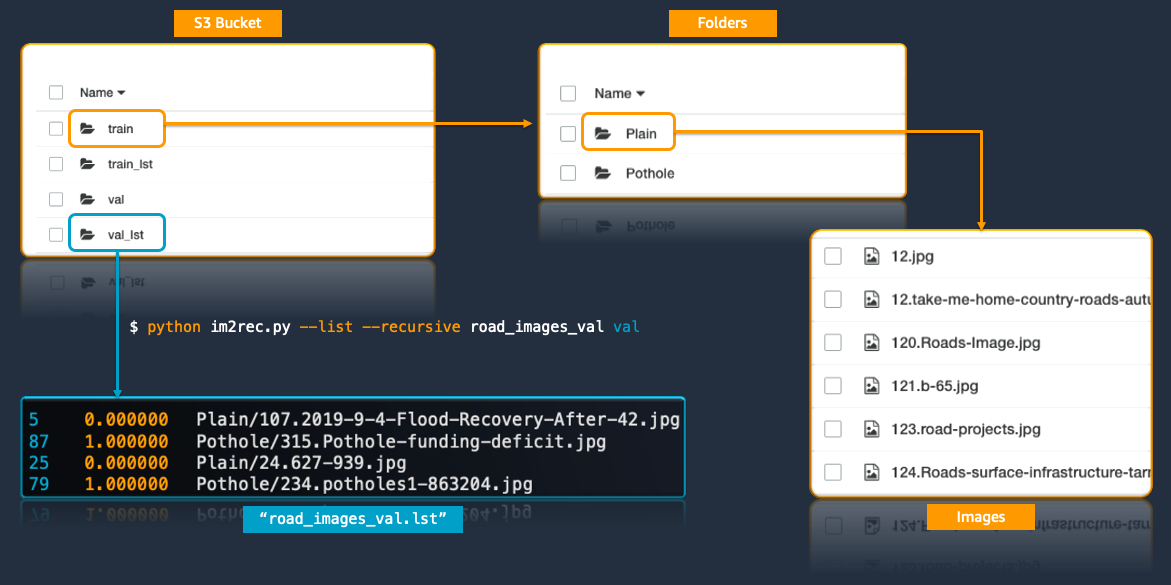

In [19]:
Image.open("img/s3_data_structure.png")

Images are described in a `lst file`, a text file containing a line per image. 
For image classification, three columns are present: 

- `unique identifier` of the image
- `class` label
- `path`

We can use a simple program that is part of Apache MXNet to create this `lst file`. 

This program is called `im2rec.py`, and it's available in Python and C++.

In [20]:
# Testing 
s3_train_path     = 's3://{}/{}/input/train/'.format(bucket, prefix)
s3_train_lst_path = 's3://{}/{}/input/train_lst/'.format(bucket, prefix)

# Validation 

s3_val_path       = 's3://{}/{}/input/val/'.format(bucket, prefix)
s3_val_lst_path   = 's3://{}/{}/input/val_lst/'.format(bucket, prefix)

# Output 
s3_output         = 's3://{}/{}/output/'.format(bucket, prefix)

print(s3_train_path)
print(s3_val_path)
print(s3_train_lst_path)
print(s3_val_lst_path)
print(s3_output)

s3://aws-ml-demo-2020/scenedataset/input/train/
s3://aws-ml-demo-2020/scenedataset/input/val/
s3://aws-ml-demo-2020/scenedataset/input/train_lst/
s3://aws-ml-demo-2020/scenedataset/input/val_lst/
s3://aws-ml-demo-2020/scenedataset/output/


### Get the name of the image classification algorithm in our region

SageMaker algorithms are packaged in Docker containers.

Using boto3 and `get_image_uri()` API, we can easily find the name of the `image-classification` algorithm in the region

In [21]:
from sagemaker import image_uris 

region_name = boto3.Session().region_name
container = image_uris.retrieve('image-classification',region_name)

print(container)

811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:1


In [22]:
## SageMaker SDK v1

# from sagemaker.amazon.amazon_estimator import get_image_uri

# region_name = boto3.Session().region_name
# container   = get_image_uri(region_name, "image-classification", "latest")

### 1. Configure the training job

Once we know the name of the container, we can configure our training job
with the `Estimator` object. In addition to the container name, we also pass the
IAM role that SageMaker instances will use, the instance type and instance count
to use for training, as well as the output location for the model. 

Estimator will generate a training job automatically

In [23]:
role = sagemaker.get_execution_role()

ic = sagemaker.estimator.Estimator(container,
                                   role, 
                                   instance_count=1, 
                                   instance_type='ml.p2.8xlarge',
                                   output_path=s3_output,
                                   sagemaker_session=session)

### 2. Set algorithm parameters

In [24]:
ic.set_hyperparameters(num_layers=50,               # The number of layers in each set is based on the ResNet paper
                       use_pretrained_model=1,      # Flag to use pre-trained model for training
                       num_classes=6,               # Plain Road or Pothole Road
                       num_training_samples=14034,    # Number of training samples
                       mini_batch_size=128,
                       resize=224,
                       learning_rate=0.01,
                       epochs=5)                   # Learn the training samples 10 times

### 3. Set dataset parameters

In [25]:
from sagemaker import TrainingInput

train_data = TrainingInput(s3_train_path, 
                           distribution='FullyReplicated', 
                           content_type='application/x-image',
                           s3_data_type='S3Prefix')

val_data  = TrainingInput(s3_val_path,
                          distribution='FullyReplicated', 
                          content_type='application/x-image', 
                          s3_data_type='S3Prefix')

train_lst_data = TrainingInput(s3_train_lst_path, 
                               distribution='FullyReplicated', 
                               content_type='application/x-image',
                               s3_data_type='S3Prefix')

val_lst_data = TrainingInput(s3_val_lst_path,
                             distribution='FullyReplicated', 
                             content_type='application/x-image', 
                             s3_data_type='S3Prefix')

s3_channels = {'train': train_data, 
               'validation': val_data, 
               'train_lst': train_lst_data, 
               'validation_lst': val_lst_data}

### 4. Train the model

In [26]:
%%time

ic.fit(inputs=s3_channels)

2020-11-25 03:46:21 Starting - Starting the training job...
2020-11-25 03:46:24 Starting - Launching requested ML instances.........
2020-11-25 03:48:09 Starting - Preparing the instances for training.........
2020-11-25 03:49:47 Downloading - Downloading input data...............
2020-11-25 03:52:08 Training - Downloading the training image..Docker entrypoint called with argument(s): train
[11/25/2020 03:52:35 INFO 140221823014720] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/image_classification/default-input.json: {u'beta_1': 0.9, u'gamma': 0.9, u'beta_2': 0.999, u'optimizer': u'sgd', u'use_pretrained_model': 0, u'eps': 1e-08, u'epochs': 30, u'lr_scheduler_factor': 0.1, u'num_layers': 152, u'image_shape': u'3,224,224', u'precision_dtype': u'float32', u'mini_batch_size': 32, u'weight_decay': 0.0001, u'learning_rate': 0.1, u'momentum': 0}
[11/25/2020 03:52:35 INFO 140221823014720] Merging with provided configuration from /opt/ml/input/config/hyperparamete

### 5. Deploy the model

In [27]:
ic_predictor = ic.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

---------------------!

### 6. Test and Validation

In [32]:
from glob import glob

test_folders = sorted(glob('scenedataset/pred/*'))
len(test_folders)

7301

In [33]:
import cv2

def load_image(img_path, resize=True):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    
    if resize:
        img = cv2.resize(img, (64,64), interpolation = cv2.INTER_AREA)
    
    return img

def show_image(img_path):
    img = load_image(img_path)
    plt.imshow(img)
    plt.axis('off')
    
def show_sign_grid(image_paths):
    images = [load_image(img) for img in image_paths]
    images = torch.as_tensor(images)
    images = images.permute(0, 3, 1, 2)
    grid_img = torchvision.utils.make_grid(images, nrow = 11)
    plt.figure(figsize = (24, 12))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

In [34]:
!pip install torch

     |████████████████████████████████| 12.8 MB 10.3 MB/s eta 0:00:01
     |████████████████████████████████| 776.7 MB 625 bytes/s a 0:00:01   |▎                               | 7.4 MB 12.6 MB/s eta 0:01:02     |█▋                              | 37.9 MB 75.3 MB/s eta 0:00:10     |███████▋                        | 185.7 MB 43.1 MB/s eta 0:00:14
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.


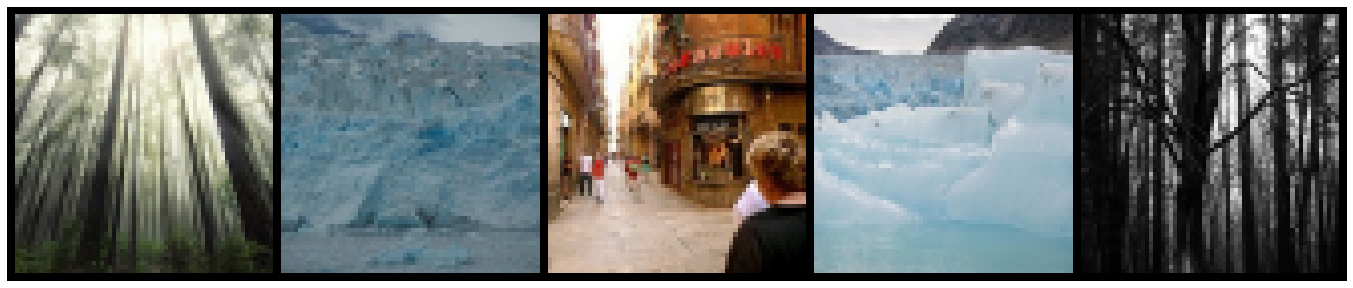

In [35]:
#Show Random Sample Image.
import torchvision
import torch
import matplotlib.pyplot as plt

sample_images = [np.random.choice(test_folders) for _ in range(5)]
show_sign_grid(sample_images)

In [36]:
sample_images

['scenedataset/pred/13990.jpg',
 'scenedataset/pred/6141.jpg',
 'scenedataset/pred/902.jpg',
 'scenedataset/pred/12189.jpg',
 'scenedataset/pred/10755.jpg']

### Predict test image

In [38]:
#Class Classification.
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
class_indices = [0, 1, 2, 3, 4, 5]


In [39]:
class_lables = dict.fromkeys(class_indices)

for k in class_lables:
    class_lables[k] = class_names[k]

In [40]:
class_lables

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

***************************************
Predicted Image : forest
Probability Distribution : [0.37524282932281494, 0.6234737634658813, 6.015062581354869e-07, 1.2219325640216994e-07, 3.0883838917361572e-06, 0.0012795882066711783]
***************************************
Predicted Image : glacier
Probability Distribution : [0.00011444563278928399, 3.122828638879582e-05, 0.998143196105957, 0.001254382194019854, 0.00040255713975057006, 5.4295946029014885e-05]
***************************************
Predicted Image : street
Probability Distribution : [0.0004750945372506976, 7.45082502362493e-07, 2.4513071821274934e-06, 5.766769845649833e-06, 1.276449802389834e-05, 0.9995031356811523]
***************************************
Predicted Image : glacier
Probability Distribution : [0.0004419672186486423, 2.2912331587576773e-07, 0.9994420409202576, 3.301588731119409e-05, 1.3557350939663593e-06, 8.151507063303143e-05]
***************************************
Predicted Image : forest
Probability Distri

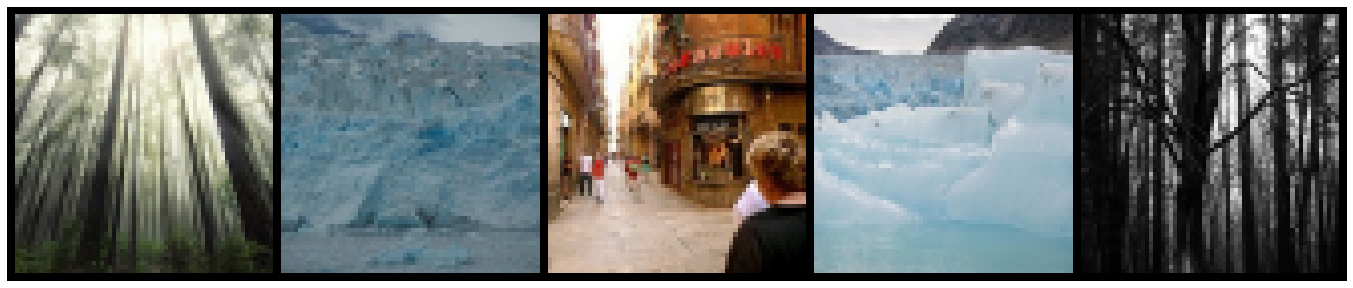

In [42]:
for file_name in sample_images:
    # Load test image from file
    with open(file_name, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)


    # Predict image and print result
    result = ic_predictor.predict(payload, initial_args={"ContentType": "application/x-image"})
    result = json.loads(result)
    class_max_pro = np.argmax(result)
    class_prediction = class_lables[class_max_pro]

    print("***************************************")
    print(f"Predicted Image : {class_prediction}")
    print(f"Probability Distribution : {result}")

print("***************************************")
show_sign_grid(sample_images)

### 7. Delete endpoint

In [43]:
#ic_predictor.delete_endpoint()